# **PACE Stages**: **The Project Framework**

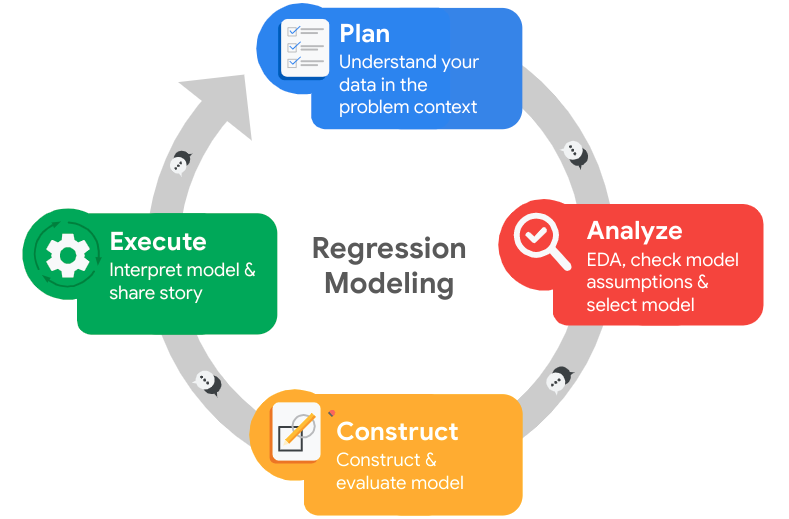

# Pace: Plan Stage

## Case Study Introduction:

The modeling objective is to build and test a classification model that uses banking data to predict whether a customer will churn.

If a customer churns, it means they left the bank and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do.

These measures could be promotions, discounts, or other incentives to boost customer satisfaction and, therefore, retention.

Our data dictionary shows that there is a column called Exited. This is a Boolean value that indicates whether or not a customer left the bank (0 = did not leave, 1 = did leave)

This will be our target variable. In other words, for each customer, our model should predict whether he should have a 0 or a 1 in the Exited column.

Upon that, We conclude the key considerations in the following points:

>  **Modeling objective:** To predict whether a customer will churn&mdash;a binary classification task.

>  **Target variable:** `Exited` column&mdash;0 or 1.  

>  **Class balance:** The data is imbalanced 80/20 (not churned/churned).

>  **Primary evaluation metric:** F1 score.

>  **Modeling workflow and model selection:** The champion model will be the model with the best validation F1 score.

## Step 1. Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score,\
                            ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')

# This module lets us save our models once we fit them.
import pickle

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

## Step 2. Data Exploration (Initial EDA and data cleaning)

### Gather basic information about the data

In [2]:
original_df = pd.read_csv(r"D:\Google Advanced Data Analytics\Nuts & Bolts of Machine Learning\Churn_Modelling.csv")
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [3]:
original_df.describe(include= "all")

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


### Check missing values

In [4]:
original_df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Check duplicates

In [5]:
original_df.duplicated().sum()

0

### Check outliers

In [6]:
sns.set_style("whitegrid")
sns.set_palette("Dark2")

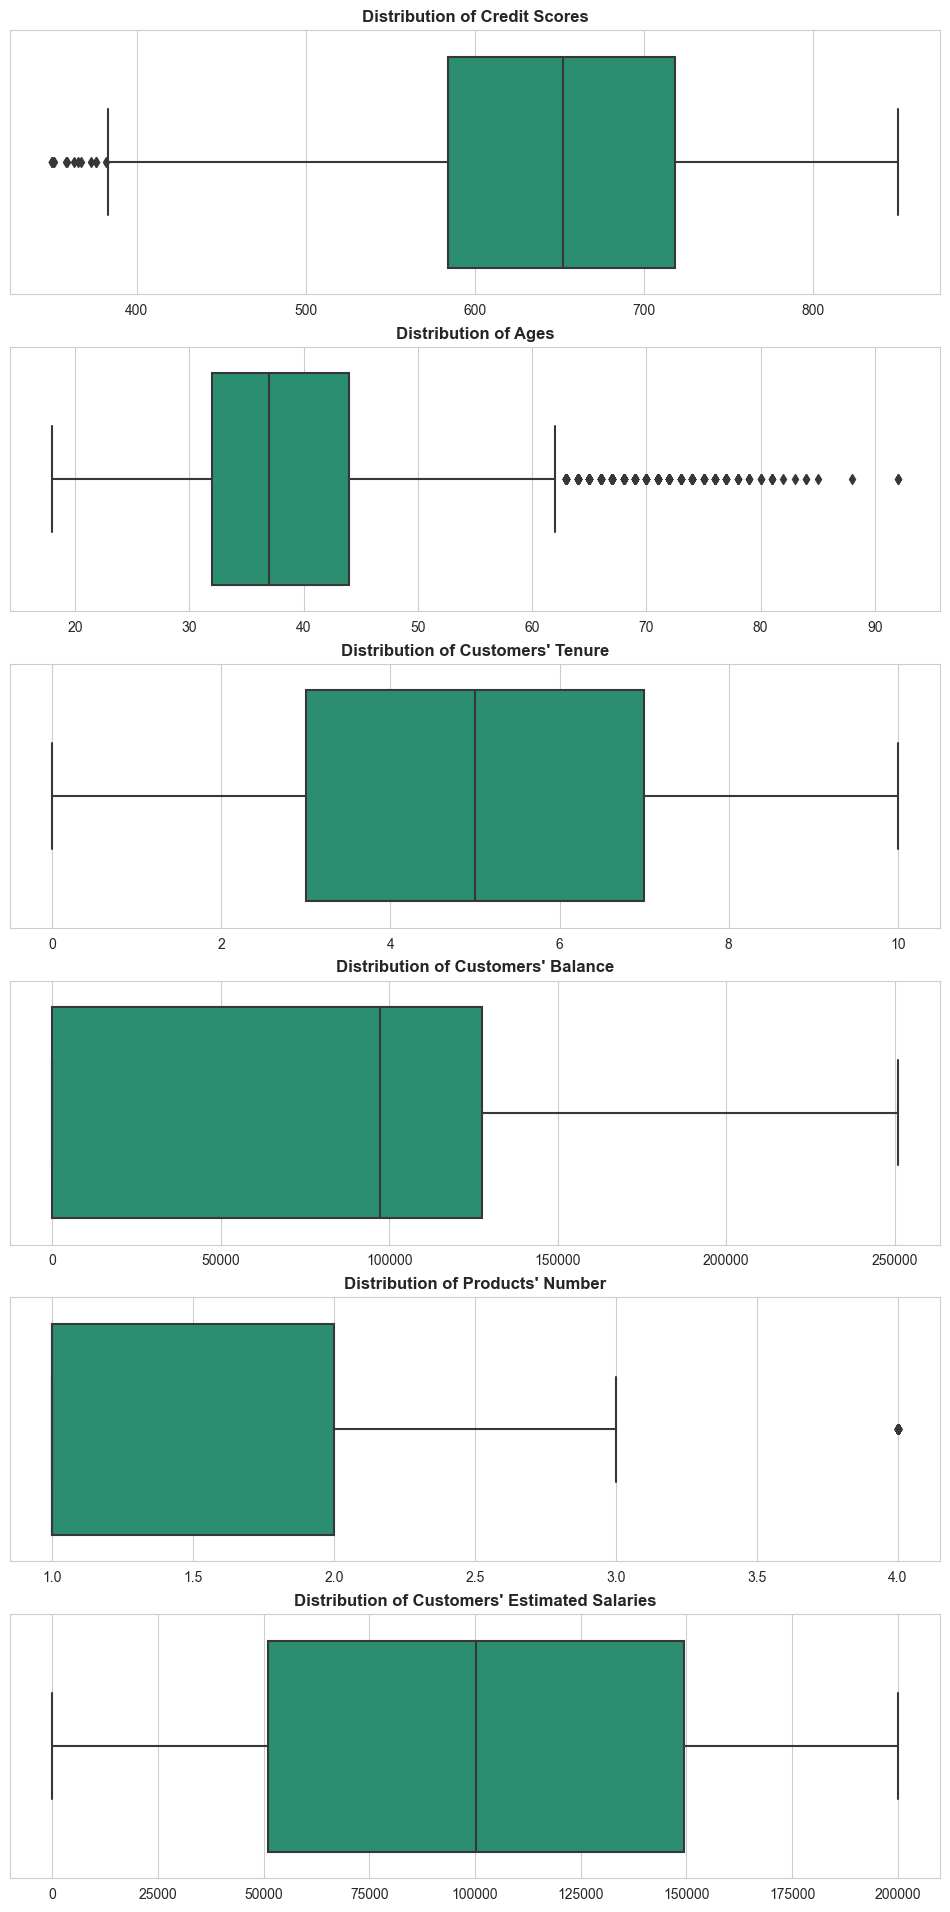

In [7]:
fig, ax = plt.subplots(6, 1, figsize= (12, 24))

sns.boxplot(x= original_df["CreditScore"], showfliers= True, ax= ax[0])
ax[0].set_title("Distribution of Credit Scores", fontsize= 12, fontweight= "bold")
ax[0].set_xlabel("")

sns.boxplot(x= original_df["Age"], showfliers= True, ax= ax[1])
ax[1].set_title("Distribution of Ages", fontsize= 12, fontweight= "bold")
ax[1].set_xlabel("")

sns.boxplot(x= original_df["Tenure"], showfliers= True, ax= ax[2])
ax[2].set_title("Distribution of Customers' Tenure", fontsize= 12, fontweight= "bold")
ax[2].set_xlabel("")

sns.boxplot(x= original_df["Balance"], showfliers= True, ax= ax[3])
ax[3].set_title("Distribution of Customers' Balance", fontsize= 12, fontweight= "bold")
ax[3].set_xlabel("")

sns.boxplot(x= original_df["NumOfProducts"], showfliers= True, ax= ax[4])
ax[4].set_title("Distribution of Products' Number", fontsize= 12, fontweight= "bold")
ax[4].set_xlabel("")

sns.boxplot(x= original_df["EstimatedSalary"], showfliers= True, ax= ax[5])
ax[5].set_title("Distribution of Customers' Estimated Salaries", fontsize= 12, fontweight= "bold")
ax[5].set_xlabel("")

plt.show()

In [8]:
def num_outliers(column_name:str):
    percentile_25 = original_df[column_name].quantile(0.25)
    percentile_75 = original_df[column_name].quantile(0.75)
    iqr = percentile_75 - percentile_25
    upper_limit = percentile_75 + 1.5 * iqr
    lower_limit = percentile_25 - 1.5 * iqr
    num_outliers = len(original_df[(original_df[column_name] > upper_limit) | (original_df[column_name] < lower_limit)])

    print("Upper Limit =", upper_limit)
    print("Lower Limit =", lower_limit)
    print("Number of outliers =", num_outliers)

In [9]:
num_outliers("CreditScore")

Upper Limit = 919.0
Lower Limit = 383.0
Number of outliers = 15


In [10]:
num_outliers("Age")

Upper Limit = 62.0
Lower Limit = 14.0
Number of outliers = 359


In [11]:
num_outliers("NumOfProducts")

Upper Limit = 3.5
Lower Limit = -0.5
Number of outliers = 60


# pAce: Analyze Stage

## Step 2. Data Exploration (Continue EDA)

In [12]:
original_df.groupby(["Exited"])[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]].median(numeric_only= True)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,653.0,36.0,5.0,92072.68,2.0,1.0,1.0,99645.04
1,646.0,45.0,5.0,109349.29,1.0,1.0,0.0,102460.84


From the above grouping, we notice the following:
1. on median the churned customer has less credit score with 7 points than the retained customer, given that the credit score ranges between 350 to 850 points.
2. on median the churned customer ages 9 years older than the retained customer.
3. on median the churned customer has almost 18000 dollars on their balance greater than the retained customer.

### Data Visualizations 1: Proportions

In [13]:
original_df["Exited"].value_counts(normalize= True) * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

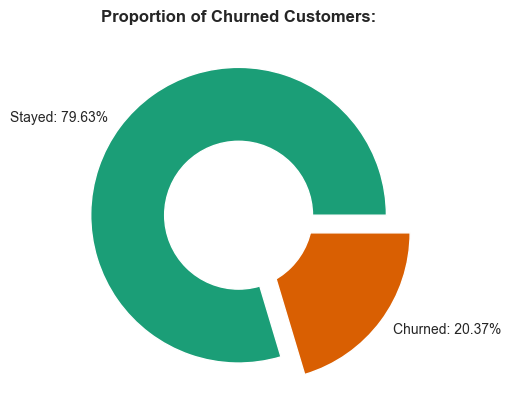

In [14]:
plt.pie(original_df["Exited"].value_counts(), labels= ["Stayed: 79.63%", "Churned: 20.37%"], explode= [0, 0.2])
my_circle = plt.Circle( (0,0), 0.5, color= 'white')
p= plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Proportion of Churned Customers:", fontweight= "bold")
plt.show()

In [15]:
original_df["Geography"].value_counts(normalize= True) * 100

France     50.14
Germany    25.09
Spain      24.77
Name: Geography, dtype: float64

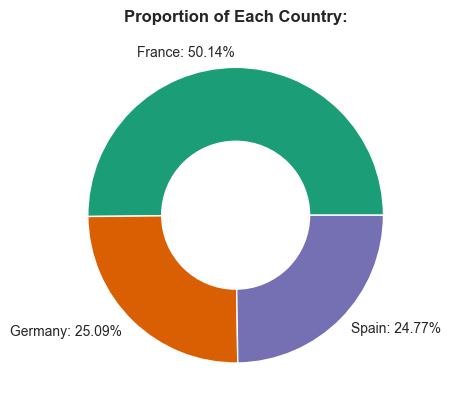

In [16]:
plt.pie(original_df["Geography"].value_counts(), labels= ["France: 50.14%", "Germany: 25.09%", "Spain: 24.77%"])
my_circle = plt.Circle( (0,0), 0.5, color= 'white')
p= plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Proportion of Each Country:", fontweight= "bold")
plt.show()

In [17]:
original_df["HasCrCard"].value_counts(normalize= True) * 100

1    70.55
0    29.45
Name: HasCrCard, dtype: float64

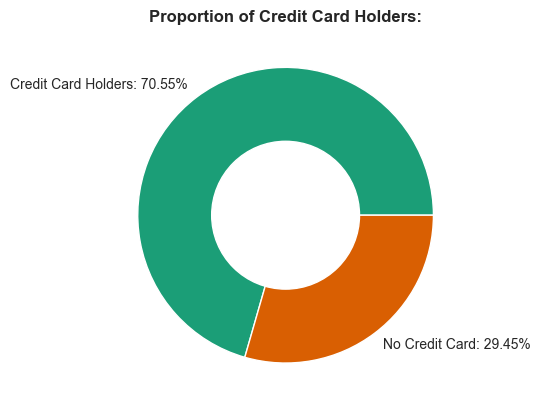

In [18]:
plt.pie(original_df["HasCrCard"].value_counts(), labels= ["Credit Card Holders: 70.55%", "No Credit Card: 29.45%"])
my_circle = plt.Circle( (0,0), 0.5, color= 'white')
p= plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Proportion of Credit Card Holders:", fontweight= "bold")
plt.show()

In [19]:
original_df["IsActiveMember"].value_counts(normalize= True) * 100

1    51.51
0    48.49
Name: IsActiveMember, dtype: float64

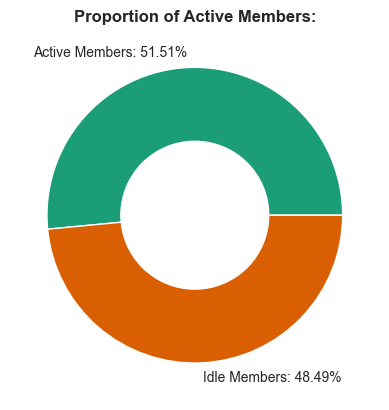

In [20]:
plt.pie(original_df["IsActiveMember"].value_counts(), labels= ["Active Members: 51.51%", "Idle Members: 48.49%"])
my_circle = plt.Circle( (0,0), 0.5, color= 'white')
p= plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Proportion of Active Members:", fontweight= "bold")
plt.show()

### Data Visualizations 2: Relationships

In [21]:
original_df["NumOfProducts"].value_counts(normalize= True) * 100

1    50.84
2    45.90
3     2.66
4     0.60
Name: NumOfProducts, dtype: float64

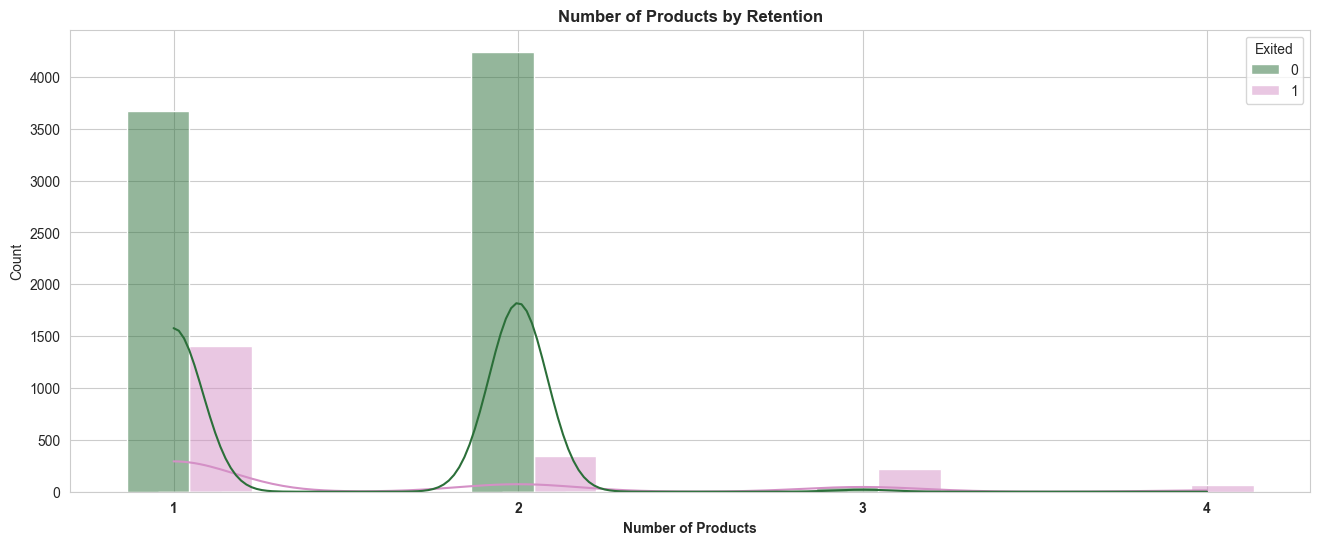

In [22]:
plt.figure(figsize= (16, 6))
sns.histplot(data= original_df, x= "NumOfProducts", shrink= 4, hue= "Exited", multiple= "dodge", palette= "cubehelix", kde= True)
plt.title("Number of Products by Retention", fontsize= 12, fontweight= "bold")

plt.xlabel("Number of Products", fontsize= 10, fontweight= "bold")
plt.xticks([1, 2, 3, 4], fontweight= "bold")
plt.show()

**It's obvious from the above histogram that proportion of customers who have more than 2 products is less than 5% of all customers, and that percentage of churned customers who have 2 products is less than those who have only one product, let's explore than further regarding the customers' age and balance.**

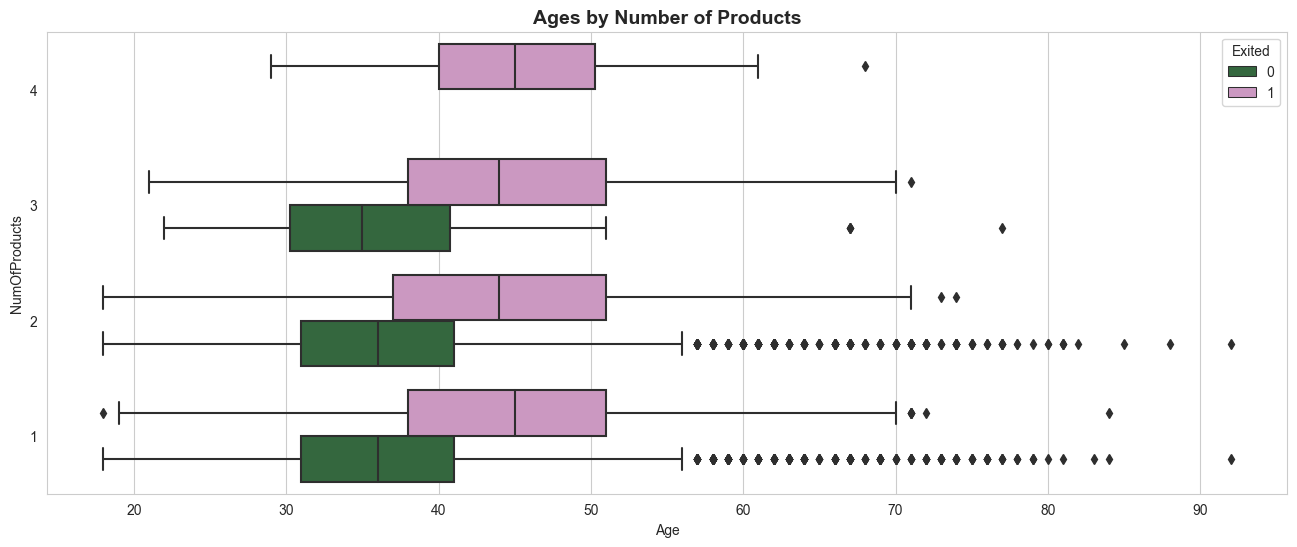

In [23]:
plt.figure(figsize= (16, 6))
box = sns.boxplot(data= original_df, x= 'Age', y= 'NumOfProducts', hue= 'Exited', orient="h", palette= "cubehelix")
box.invert_yaxis()

plt.title("Ages by Number of Products", fontsize= 14, fontweight= "bold")
plt.show()

**From the above boxplots, we conclude that the median age of retained customers is 36 years, while that of churned customers is 45 years.**

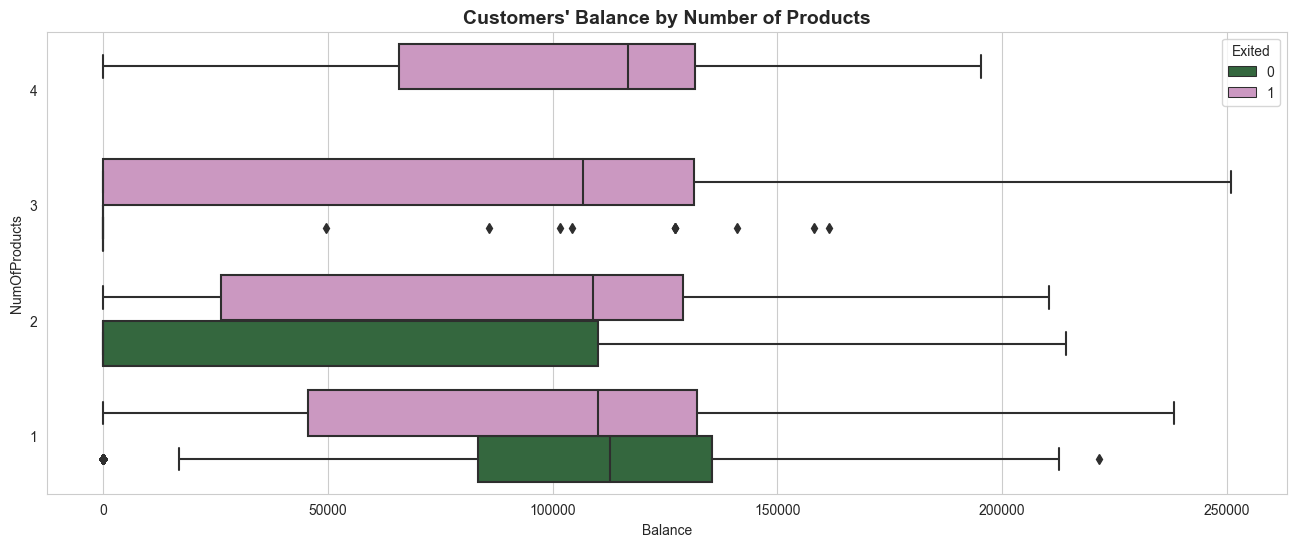

In [24]:
plt.figure(figsize= (16, 6))
box = sns.boxplot(data= original_df, x= 'Balance', y= 'NumOfProducts', hue= 'Exited', orient="h", palette= "cubehelix")
box.invert_yaxis()

plt.title("Customers' Balance by Number of Products", fontsize= 14, fontweight= "bold")
plt.show()

In [25]:
original_df["Tenure"].value_counts(normalize= True) * 100

2     10.48
1     10.35
7     10.28
8     10.25
5     10.12
3     10.09
4      9.89
9      9.84
6      9.67
10     4.90
0      4.13
Name: Tenure, dtype: float64

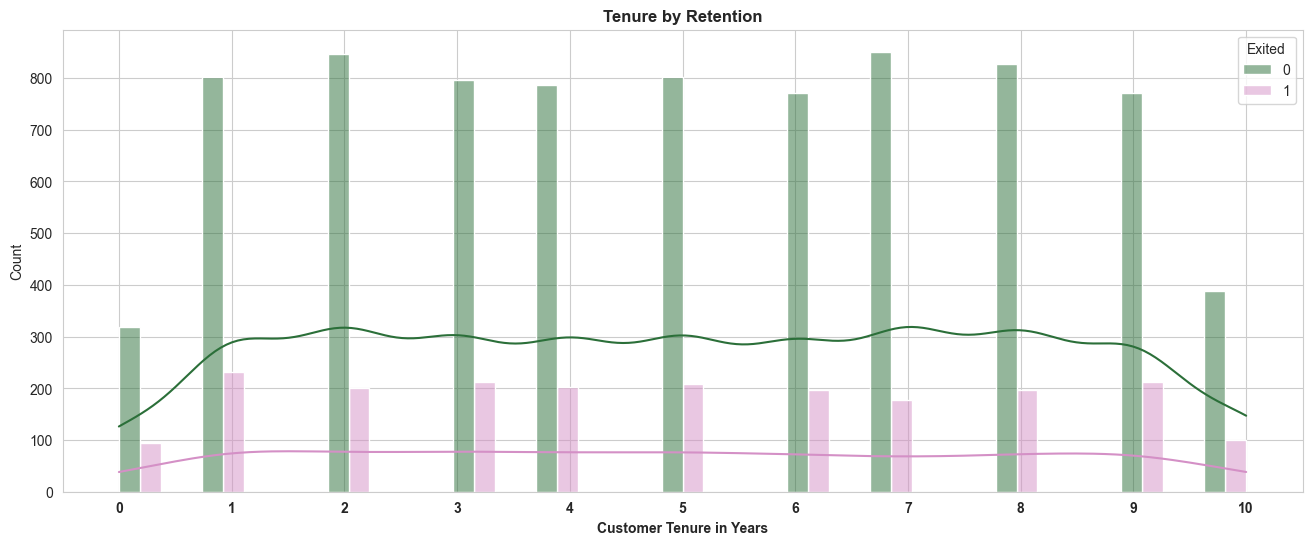

In [26]:
plt.figure(figsize= (16, 6))
sns.histplot(data= original_df, x= "Tenure", hue= "Exited", multiple= "dodge", palette= "cubehelix", kde= True)
plt.title("Tenure by Retention", fontsize= 12, fontweight= "bold")

plt.xlabel("Customer Tenure in Years", fontsize= 10, fontweight= "bold")
plt.xticks(range(0, 11), fontweight= "bold")
plt.show()

**The homogeneous distribution of customers' tenure is obvious, however the proportion of churned customers are roughly stable across all tenures.**

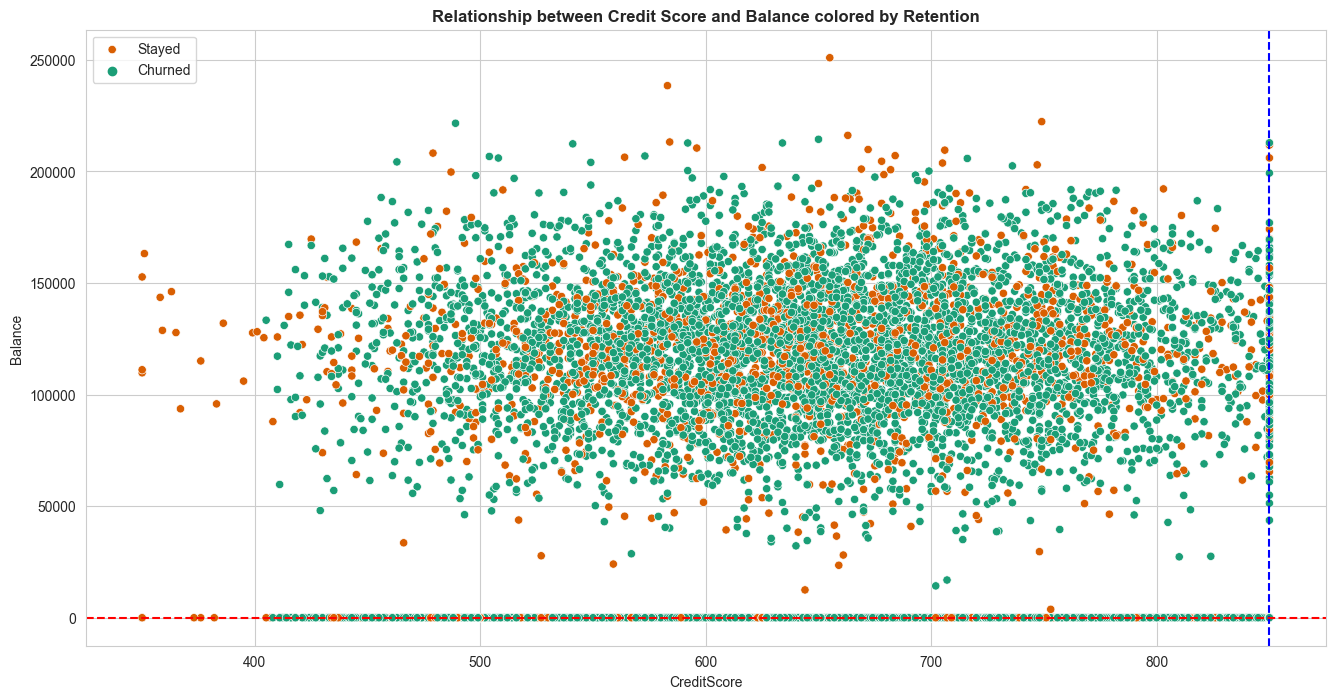

In [27]:
plt.figure(figsize= (16, 8))
sns.scatterplot(data= original_df, x= "CreditScore", y= "Balance", hue= "Exited")
plt.title("Relationship between Credit Score and Balance colored by Retention", fontsize= 12, fontweight= "bold")

plt.axvline(x= 850, color= "blue", ls= "dashed")
plt.axhline(y= 0, color= "red", ls= "dashed")
plt.legend(["Stayed", "Churned"])
plt.show()

**From the above scatter plot, we can draw 3 conclusions, which are:**
1. Churned customers are distributed across all credit scores and account balance.
2. There are considerable proportion of customers who have a balance of Zero.
3. There are many customers have the full credit score of 850 points.

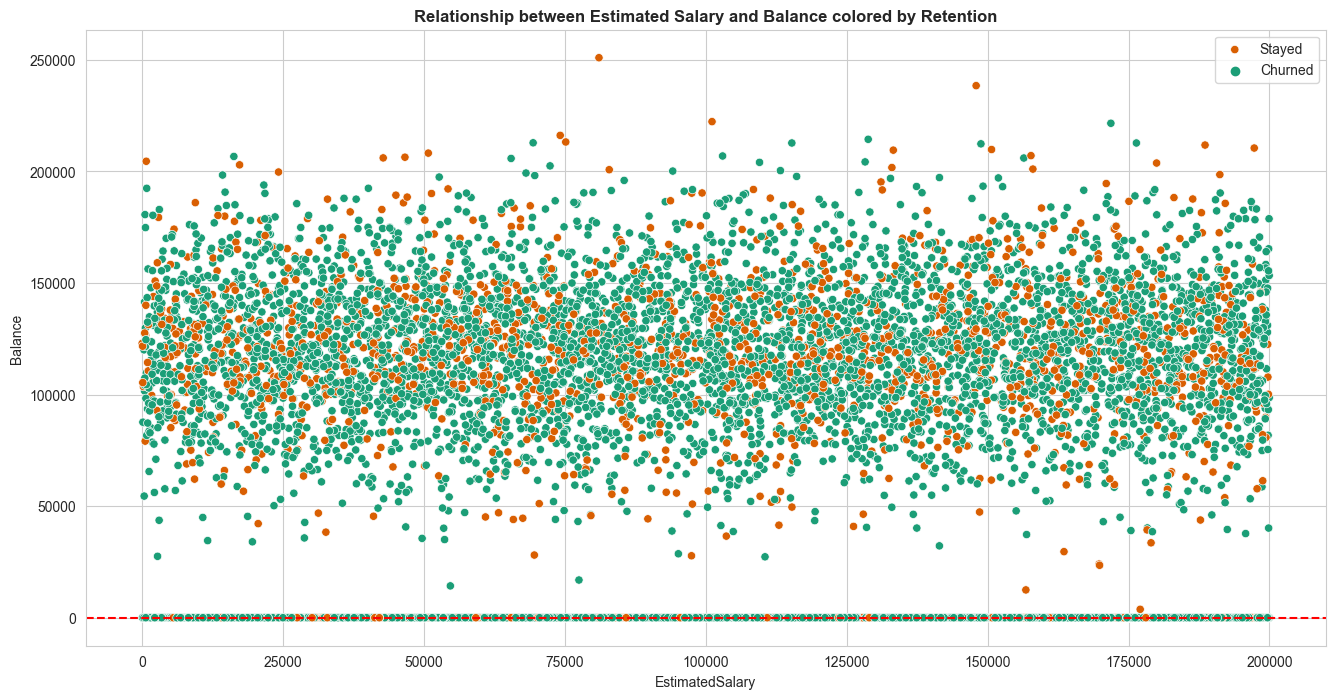

In [28]:
plt.figure(figsize= (16, 8))
sns.scatterplot(data= original_df, x= "EstimatedSalary", y= "Balance", hue= "Exited")
plt.title("Relationship between Estimated Salary and Balance colored by Retention", fontsize= 12, fontweight= "bold")

plt.axhline(y= 0, color= "red", ls= "dashed")
plt.legend(["Stayed", "Churned"])
plt.show()

**The estimated salary variable is distributed very homogeneously across customers, which may be a data collection error or due to data synthesis.**

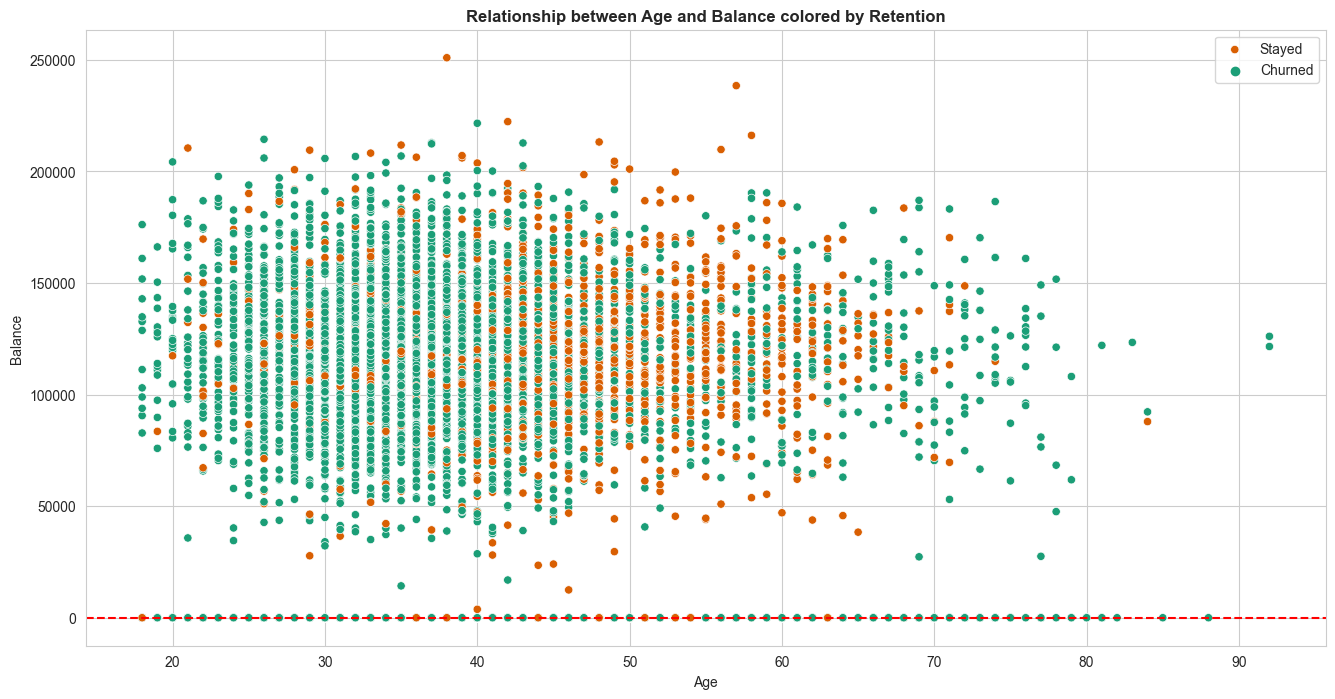

In [29]:
plt.figure(figsize= (16, 8))
sns.scatterplot(data= original_df, x= "Age", y= "Balance", hue= "Exited")
plt.title("Relationship between Age and Balance colored by Retention", fontsize= 12, fontweight= "bold")

plt.axhline(y= 0, color= "red", ls= "dashed")
plt.legend(["Stayed", "Churned"])
plt.show()

**We can easily observe from the above scatter plot how proportion of churned customers increases with aging.**

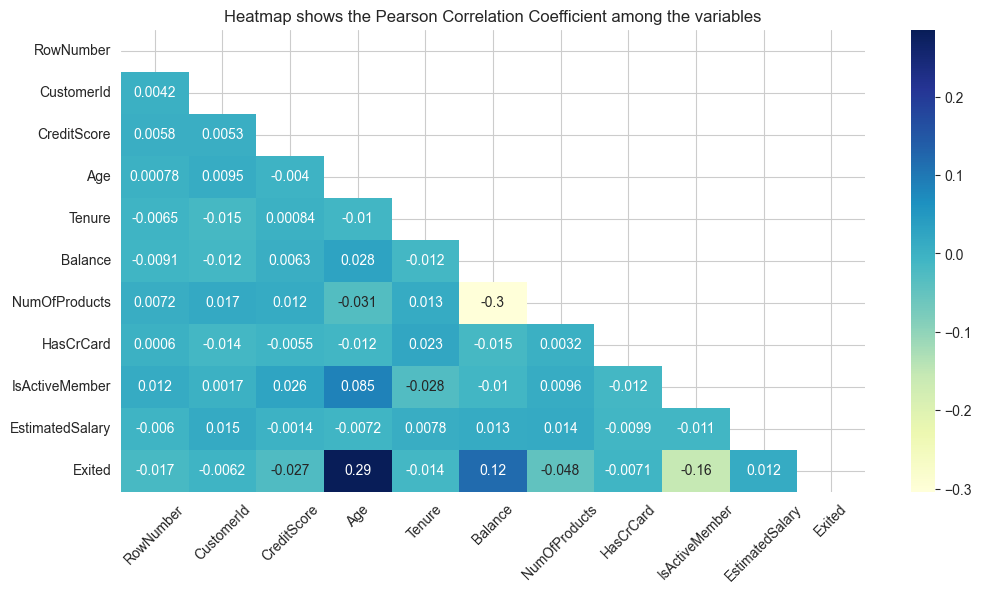

In [30]:
plt.figure(figsize= (12, 6))

mask_heatmap = np.triu(np.ones_like(original_df.corr(numeric_only= True)))
fig = sns.heatmap(data= original_df.corr(numeric_only= True), annot= True, cmap= "YlGnBu", mask= mask_heatmap)
fig.set_title("Heatmap shows the Pearson Correlation Coefficient among the variables")

plt.xticks(rotation= 45)
plt.show()

**The heatmap shows a positive correlation between the target variable `Exited` and each of the `Age`and the `Balance` variables, while there is a negative correlation between the target variable and whether the customer is active or not. These assumptions is important before the modelling to understand relationships between the features.**

In [31]:
#The cost of every churned customer:
avg_churned_bal = round(original_df[original_df["Exited"] == 1]["Balance"].mean(), 2)
avg_churned_bal

91108.54

## Feature Engineering:

### Feature Extraction:

In [32]:
original_df["Loyalty"] = round(original_df["Tenure"] / original_df["Age"] * 100, 2)
original_df["Loyalty"].describe()

count    10000.000000
mean        13.793457
std          8.950456
min          0.000000
25%          6.450000
50%         12.900000
75%         20.000000
max         55.560000
Name: Loyalty, dtype: float64

### Feature Selection:

In [33]:
churn_df = original_df.drop(["RowNumber", "CustomerId", "Surname", "Gender"], axis= 1)
churn_df.head(5)

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty
0,619,France,42,2,0.00,1,1,1,101348.88,1,4.76
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0,2.44
2,502,France,42,8,159660.80,3,1,0,113931.57,1,19.05
3,699,France,39,1,0.00,2,0,0,93826.63,0,2.56
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0,4.65


### Feature Transformation:

In [34]:
churn_df["Geography"].value_counts(normalize= True) * 100

France     50.14
Germany    25.09
Spain      24.77
Name: Geography, dtype: float64

In [35]:
churn_df = pd.get_dummies(churn_df)
churn_df.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_France,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,4.76,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,2.44,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,19.05,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,2.56,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,4.65,0,0,1


# paCe: Construct Stage

## Modelling:

### Splitting the data:

In [36]:
y = churn_df["Exited"]

X = churn_df.copy()
X = churn_df.drop("Exited", axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, stratify= y, random_state= 42)

### Scaling the data:

**Scaling the data based on their mean and standard deviation, since the naive bayes and logistic regression models requires this scaling to perform properly.**

In [37]:
#Import the scaler function
from sklearn.preprocessing import StandardScaler

# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Scale the training data
X_train = scaler.transform(X_train)

# Scale the test data
X_test = scaler.transform(X_test)

### Oversampling the minority class:

**Oversampling the class of churned customers from 20% to 60%, since the class imbalance problem often skews the model's predictions to the majority class.**

In [38]:
# Initial class distribution in the training set
print("Original class distribution in training set:", Counter(y_train))

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy= 0.6, random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# New class distribution after resampling
print("Resampled class distribution in training set:", Counter(y_resampled))

Original class distribution in training set: Counter({0: 5972, 1: 1528})
Resampled class distribution in training set: Counter({0: 5972, 1: 3583})


## 1-Logistic Regression Model Construction:

In [39]:
%%time

lr_scaled = LogisticRegression(max_iter= 500, random_state= 17)
lr_scaled.fit(X_resampled, y_resampled)

CPU times: total: 0 ns
Wall time: 509 ms


LogisticRegression(max_iter=500, random_state=17)

In [40]:
# Get the predictions on test data
y_pred_lr_scaled = lr_scaled.predict(X_test)

In [41]:
print('F1 Score:', '%.3f' % f1_score(y_test, y_pred_lr_scaled))
print('Precision:', '%.3f' % precision_score(y_test, y_pred_lr_scaled))
print('Recall:', '%.3f' % recall_score(y_test, y_pred_lr_scaled))
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_pred_lr_scaled))

F1 Score: 0.494
Precision: 0.475
Recall: 0.515
Accuracy: 0.786


In [42]:
def conf_matrix_plot(model, x_data, y_data):
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels= model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= model.classes_)
    disp.plot(values_format= "")
    plt.show()

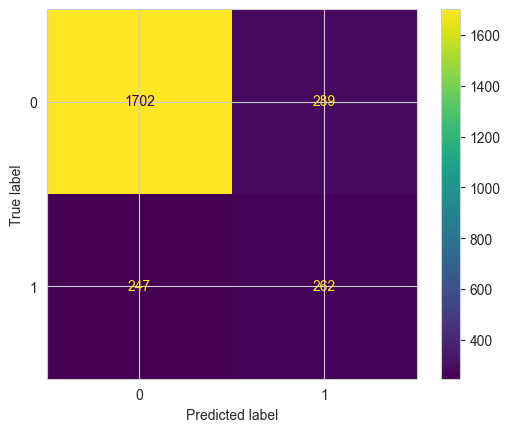

In [43]:
conf_matrix_plot(lr_scaled, X_test, y_test)

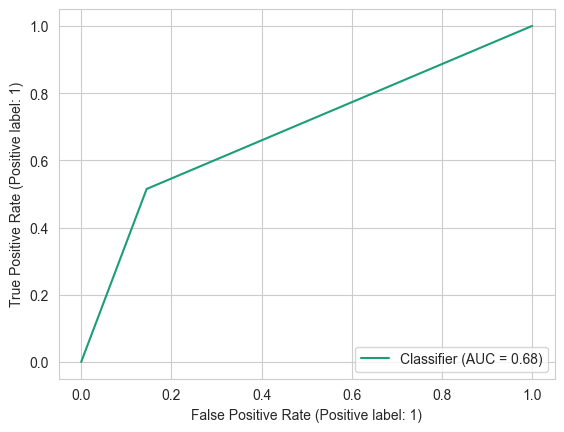

roc_auc_score: 0.685


In [44]:
RocCurveDisplay.from_predictions(y_test, y_pred_lr_scaled)
plt.show()

print("roc_auc_score:", round(roc_auc_score(y_test, y_pred_lr_scaled), 3))

## 2-Gaussian Naive Bayes Model Construction

In [45]:
%%time

gnb_scaled = GaussianNB()
gnb_scaled.fit(X_resampled, y_resampled)

CPU times: total: 0 ns
Wall time: 4.45 ms


GaussianNB()

In [46]:
# Get the predictions on test data
y_pred_gnb_scaled = gnb_scaled.predict(X_test)

In [47]:
print('F1 Score:', '%.3f' % f1_score(y_test, y_pred_gnb_scaled))
print('Precision:', '%.3f' % precision_score(y_test, y_pred_gnb_scaled))
print('Recall:', '%.3f' % recall_score(y_test, y_pred_gnb_scaled))
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_pred_gnb_scaled))

F1 Score: 0.503
Precision: 0.447
Recall: 0.576
Accuracy: 0.768


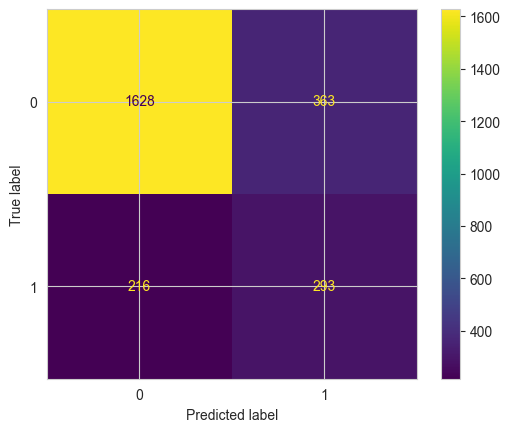

In [48]:
conf_matrix_plot(gnb_scaled, X_test, y_test)

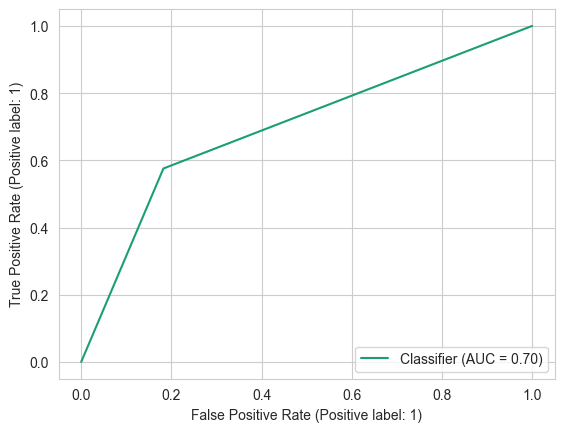

roc_auc_score: 0.697


In [49]:
RocCurveDisplay.from_predictions(y_test, y_pred_gnb_scaled)
plt.show()

print("roc_auc_score:", round(roc_auc_score(y_test, y_pred_gnb_scaled), 3))

## 3-Decision Tree Model Construction

### Splitting the data & Oversampling the minority class:

In [50]:
y = churn_df["Exited"]

X = churn_df.copy()
X = churn_df.drop("Exited", axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, stratify= y, random_state= 42)

In [51]:
# Initial class distribution in the training set
print("Original class distribution in training set:", Counter(y_train))

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy= 0.6, random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# New class distribution after resampling
print("Resampled class distribution in training set:", Counter(y_resampled))

Original class distribution in training set: Counter({0: 5972, 1: 1528})
Resampled class distribution in training set: Counter({0: 5972, 1: 3583})


In [52]:
dt = DecisionTreeClassifier(random_state= 42)

tree_para = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 10], "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8]}

scoring = ['accuracy', 'precision', 'recall', 'f1']

dt_cv = GridSearchCV(estimator= dt, param_grid= tree_para, scoring= scoring, cv= 5, refit= 'f1', n_jobs= -1, verbose= 1)

In [53]:
%%time

dt_cv.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
CPU times: total: 500 ms
Wall time: 5.47 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [54]:
print("Best Parameters for the Decision Tree Model:\n", dt_cv.best_params_)

print("\nBest Avgerage Cross-validation F1-score:", "%.3f" % dt_cv.best_score_)

Best Parameters for the Decision Tree Model:
 {'max_depth': 9, 'min_samples_leaf': 7}

Best Avgerage Cross-validation F1-score: 0.758


In [55]:
def make_results(model_name, model_object):
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results["mean_test_f1"].idxmax(), :]
    precision = best_estimator_results.mean_test_precision
    recall = best_estimator_results.mean_test_recall
    f1 = best_estimator_results.mean_test_f1
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({"Model": [model_name], "F1": [f1], "Precision": [precision], "Recall": [recall], "Accuracy": [accuracy]})
    return table

In [56]:
dt_cv_results = make_results("Decision_Tree", dt_cv)

dt_cv_results

,Model,F1,Precision,Recall,Accuracy
0,Decision_Tree,0.757611,0.799311,0.725431,0.830141


### Constructing the optimal Decision Tree Classifier based on the best cross-validation results:

In [57]:
decision_tree = DecisionTreeClassifier(max_depth= 9, min_samples_leaf= 7, random_state= 42)
decision_tree.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=7, random_state=42)

In [58]:
y_pred_dt = decision_tree.predict(X_test)

In [59]:
print('F1 Score:', '%.3f' % f1_score(y_test, y_pred_dt))
print('Precision:', '%.3f' % precision_score(y_test, y_pred_dt))
print('Recall:', '%.3f' % recall_score(y_test, y_pred_dt))
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_pred_dt))

F1 Score: 0.597
Precision: 0.596
Recall: 0.597
Accuracy: 0.836


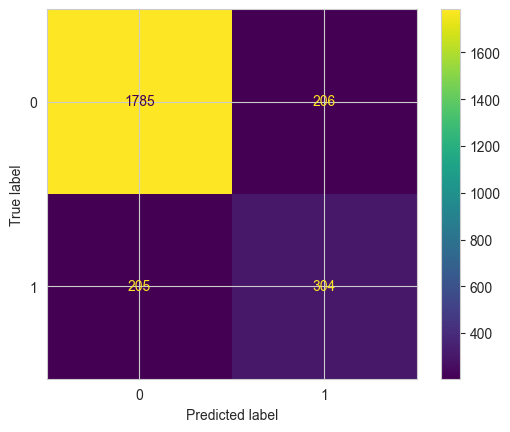

In [60]:
conf_matrix_plot(decision_tree, X_test, y_test)

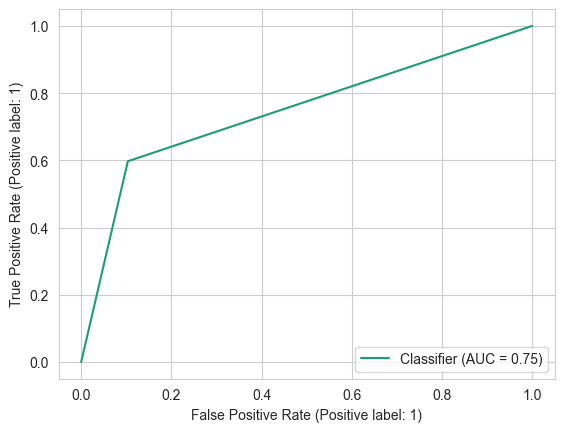

roc_auc_score: 0.747


In [61]:
RocCurveDisplay.from_predictions(y_test, y_pred_dt)
plt.show()

print("roc_auc_score:", round(roc_auc_score(y_test, y_pred_dt), 3))

In [62]:
comparing_models = pd.DataFrame()

comparing_models = comparing_models.append({"Model": "Decision_Tree", "F1": 0.597, "Precision": 0.596, "Recall": 0.597, "Accuracy": 0.836}, ignore_index= True)

comparing_models = comparing_models.append({"Model": "Naive_Bayes", "F1": 0.503, "Precision": 0.447, "Recall": 0.576, "Accuracy": 0.768}, ignore_index= True)

comparing_models = comparing_models.append({"Model": "Logistic_Regression", "F1": 0.494, "Precision": 0.475, "Recall": 0.515, "Accuracy": 0.786}, ignore_index= True)

comparing_models

,Model,F1,Precision,Recall,Accuracy
0,Decision_Tree,0.597,0.596,0.597,0.836
1,Naive_Bayes,0.503,0.447,0.576,0.768
2,Logistic_Regression,0.494,0.475,0.515,0.786


**We notice that the F1 Score -which is our benchmark- is higher in the decision tree model (0.525) than the naive bayes model (0.425) and the logistic regression model (0.439), however the False Positives are still higher than the False Negatives despite of the oversampling technique we've conducted earlier.**

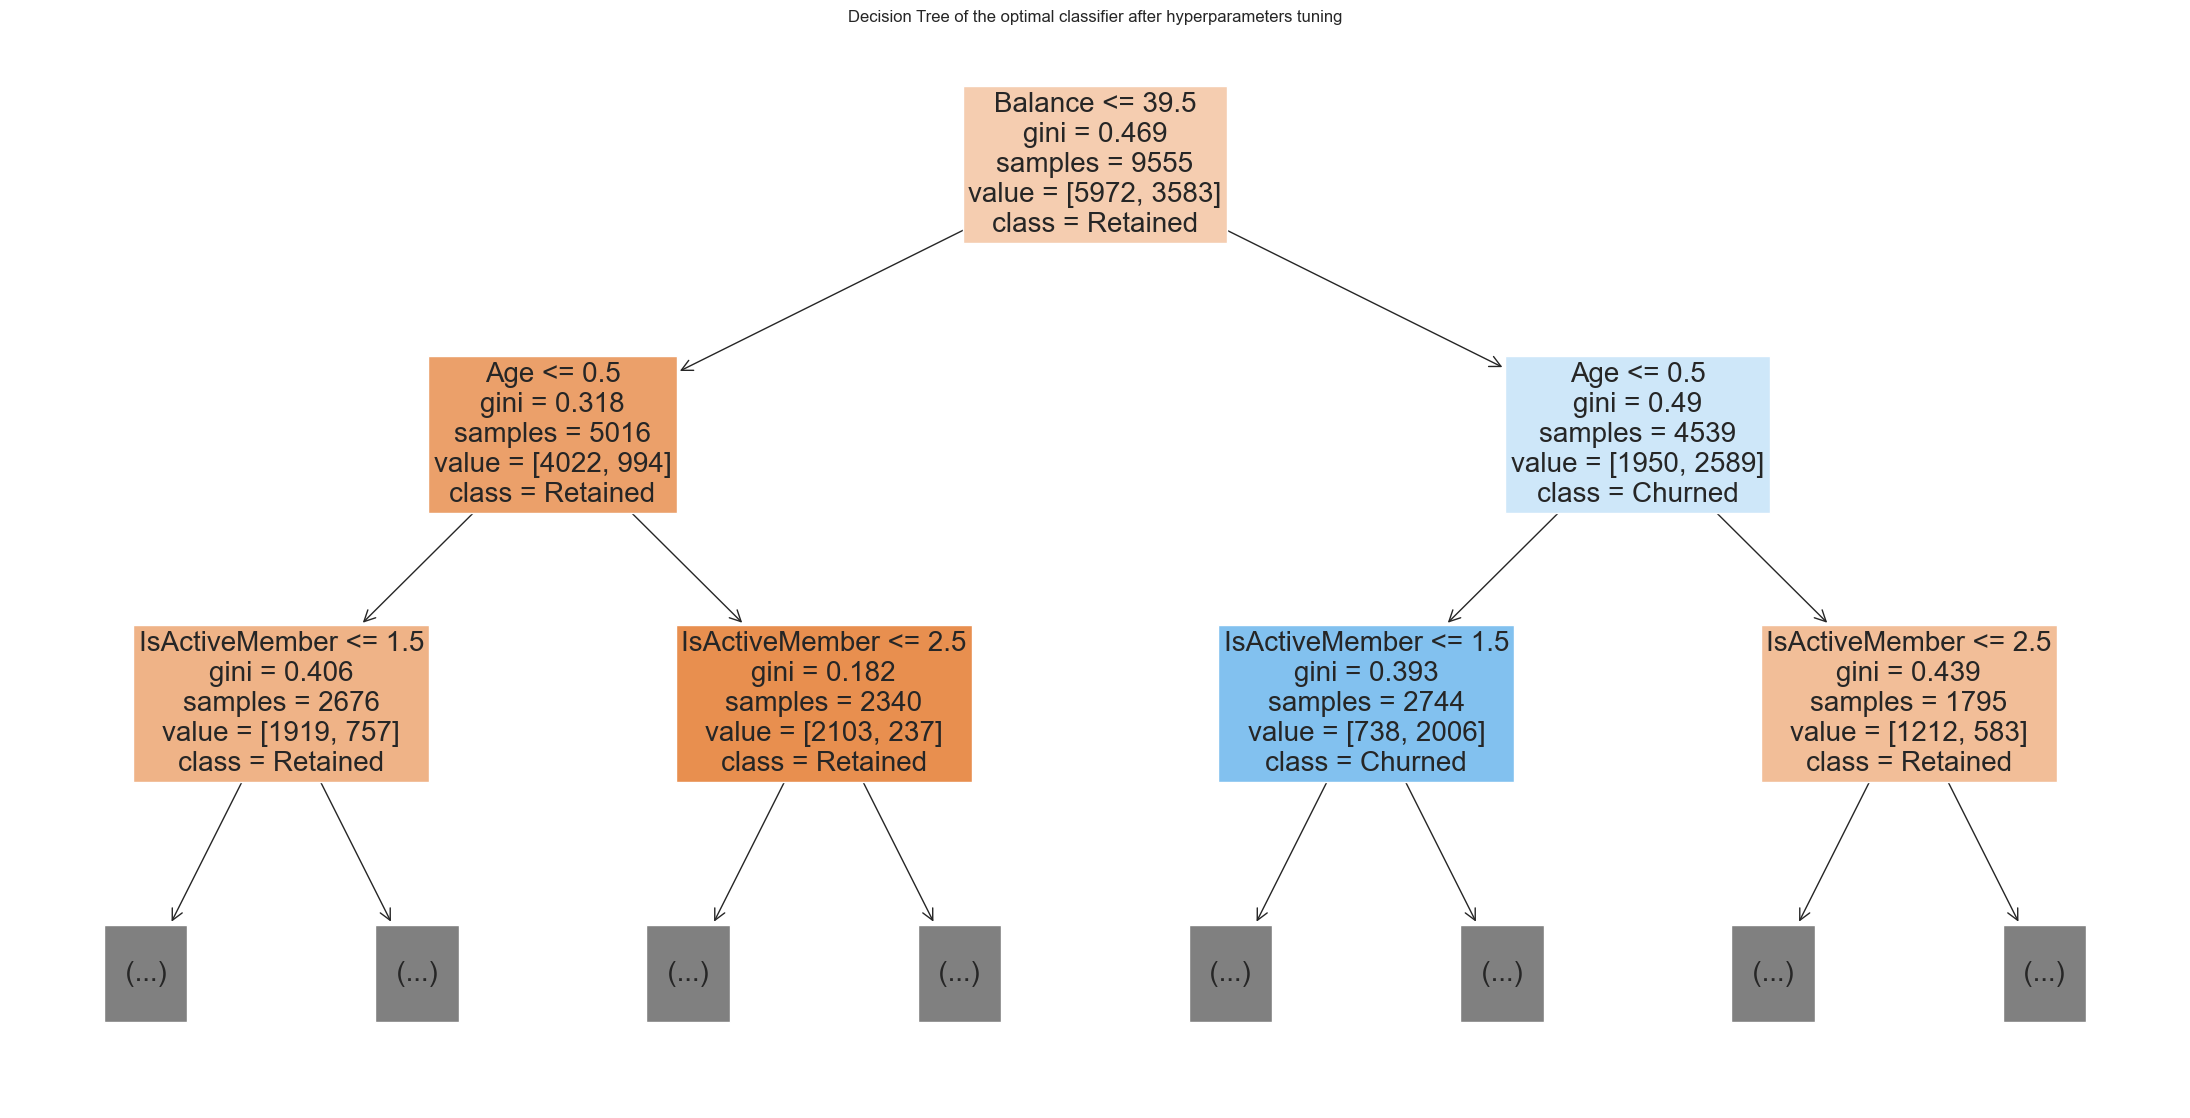

In [63]:
plt.figure(figsize= (28, 14))
plot_tree(decision_tree, max_depth= 2, fontsize= 20,
          feature_names= ['CreditScore', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Age', 'Tenure', 'Loyalty', 'Geography_Germany', 'Geography_Spain', 'Geography_France'], class_names= ["Retained", "Churned"], filled= True)
plt.title("Decision Tree of the optimal classifier after hyperparameters tuning")
plt.show()

In [64]:
importances = decision_tree.feature_importances_ * 100

forest_importances = pd.DataFrame(importances, index= X.columns, columns= ["affect"]).sort_values(by= "affect", ascending= False)
forest_importances

,affect
Age,31.298165
NumOfProducts,17.522073
IsActiveMember,16.185259
Balance,11.096547
Geography_France,6.086130
Geography_Spain,5.919848
Geography_Germany,4.395243
EstimatedSalary,3.054795
Loyalty,2.131416
CreditScore,1.745237


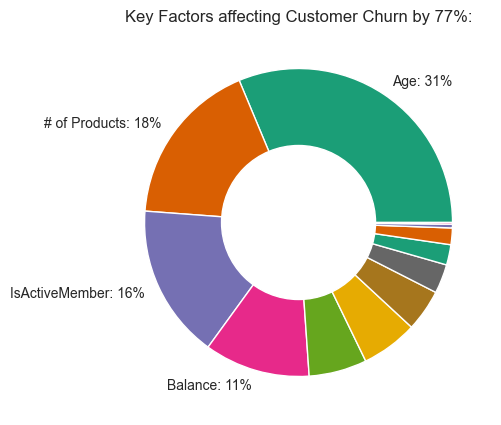

In [65]:
plt.figure( figsize= (10, 5))
plt.pie(x= forest_importances["affect"], labels= ["Age: 31%", "# of Products: 18%", "IsActiveMember: 16%", "Balance: 11%", "", "", "", "", "", "", "", ""])
plt.title("Key Factors affecting Customer Churn by 77%:")

my_circle = plt.Circle( (0,0), 0.5, color= 'white')
p= plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

**Recommendations for Stakeholders**
Based on the results of the Decision Tree algorithm, the most effective features on the customer churn rate are:
> 1- Age of the customer.

> 2- Number of Products in which the customer is being involved in.

> 3- Whether the customer is considered as active or not.

> 4- Balance Amount in the customer's account.

The algorithm determined the above features as the most effective ones by approximately 76%, while the other 5 features are not considered effective.

## 4-Random Forest Model Construction

### Cross-validated hyperparameter tuning

In [66]:
rf = RandomForestClassifier(random_state= 42)

cv_params = {'max_depth': [6, 7, 8, 9, 10],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4],
             'max_features': [2, 3, 4],
             'n_estimators': [75, 100, 125]}

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_cv = GridSearchCV(estimator= rf, param_grid= cv_params, scoring=scoring, cv=5, refit='f1', n_jobs= -1, verbose= 1)

In [67]:
#%%time

#rf_cv.fit(X_resampled, y_resampled)

In [68]:
path = "D:/Google Advanced Data Analytics/Nuts & Bolts of Machine Learning/Fitted_Models/"

In [69]:
# Pickle the model
#with open(path+'rf_cv_model.pickle', 'wb') as to_write:
#    pickle.dump(rf_cv, to_write)

In [70]:
# Read in pickled model
with open(path + 'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

In [71]:
print("Best Parameters for the Random Forest Model:\n", rf_cv.best_params_)

print("\nBest Avgerage Cross-validation F1-score:", "%.3f" % rf_cv.best_score_)

Best Parameters for the Random Forest Model:
 {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}

Best Avgerage Cross-validation F1-score: 0.788


In [72]:
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results

,Model,F1,Precision,Recall,Accuracy
0,Random Forest CV,0.788366,0.852622,0.743864,0.857143


### Constructing the optimal Random Forest Classifier based on the best cross-validation results:

In [73]:
random_forest = RandomForestClassifier(max_depth= 10, max_features= 4, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 125, random_state= 42)
random_forest.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=10, max_features=4, n_estimators=125,
                       random_state=42)

In [74]:
y_pred_rf = random_forest.predict(X_test)

In [75]:
print('F1 Score:', '%.3f' % f1_score(y_test, y_pred_rf))
print('Precision:', '%.3f' % precision_score(y_test, y_pred_rf))
print('Recall:', '%.3f' % recall_score(y_test, y_pred_rf))
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_pred_rf))

F1 Score: 0.627
Precision: 0.676
Recall: 0.585
Accuracy: 0.858


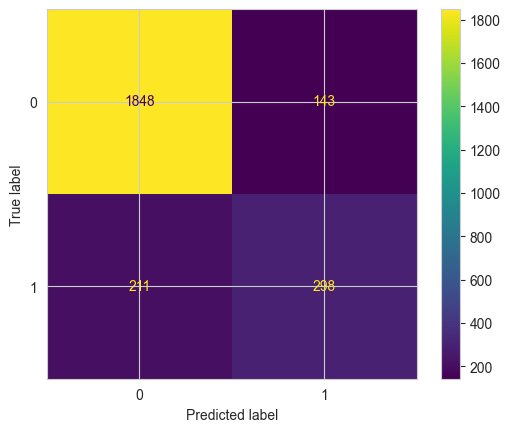

In [76]:
conf_matrix_plot(random_forest, X_test, y_test)

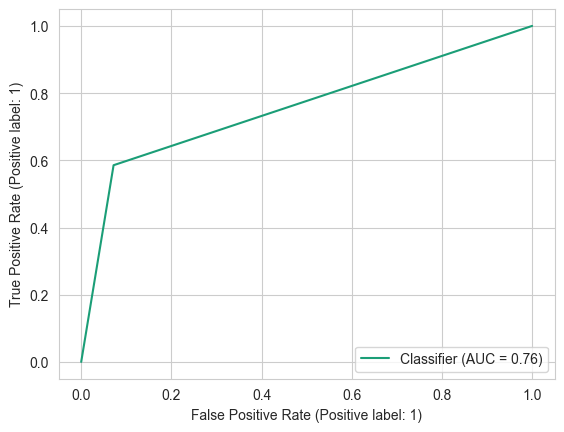

roc_auc_score: 0.757


In [77]:
RocCurveDisplay.from_predictions(y_test, y_pred_rf)
plt.show()

print("roc_auc_score:", round(roc_auc_score(y_test, y_pred_rf), 3))

In [78]:
comparing_models = comparing_models.append({"Model": "Random_Forest", "F1": 0.627, "Precision": 0.676, "Recall": 0.585, "Accuracy": 0.858}, ignore_index= True)

comparing_models = comparing_models.sort_values(by= "F1", ascending= False).reset_index(drop= True)

comparing_models

,Model,F1,Precision,Recall,Accuracy
0,Random_Forest,0.627,0.676,0.585,0.858
1,Decision_Tree,0.597,0.596,0.597,0.836
2,Naive_Bayes,0.503,0.447,0.576,0.768
3,Logistic_Regression,0.494,0.475,0.515,0.786


In [79]:
feature_importances = random_forest.feature_importances_
feature_importances

array([0.04835111, 0.26089744, 0.02279709, 0.08810593, 0.15171378,
       0.01385651, 0.12187607, 0.05356716, 0.0571959 , 0.07097223,
       0.04484391, 0.06582285])

In [80]:
forest_importances = pd.DataFrame(list(X.columns), columns= ["feature"])
forest_importances["importance"] = feature_importances * 100
forest_importances = forest_importances[forest_importances["importance"] > 0].sort_values(by="importance", ascending= False)
forest_importances

,feature,importance
1,Age,26.089744
4,NumOfProducts,15.171378
6,IsActiveMember,12.187607
3,Balance,8.810593
9,Geography_France,7.097223
11,Geography_Spain,6.582285
8,Loyalty,5.719590
7,EstimatedSalary,5.356716
0,CreditScore,4.835111
10,Geography_Germany,4.484391


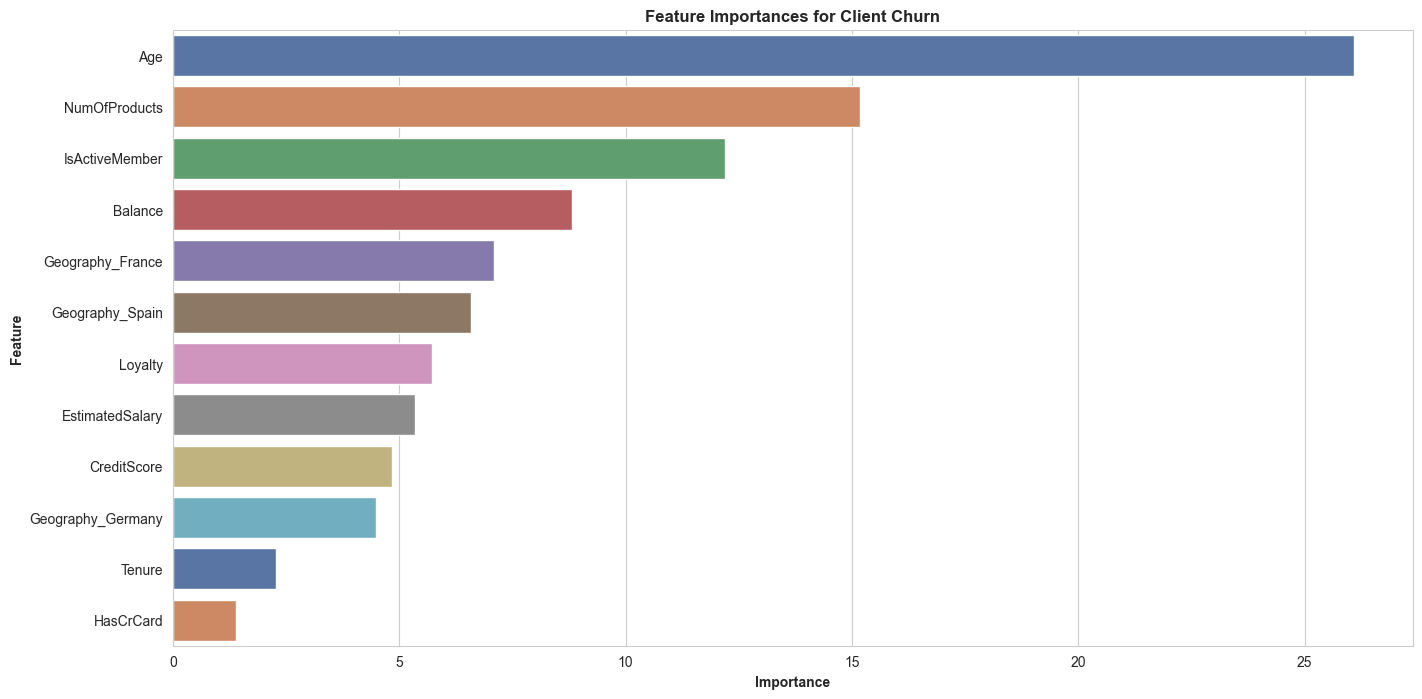

In [81]:
plt.figure(figsize= (16, 8))
sns.barplot(data= forest_importances, x= "importance", y= "feature", palette= "deep", orient= "h")
plt.title("Feature Importances for Client Churn", fontweight= "bold")
plt.ylabel("Feature", fontweight= "bold")
plt.xlabel("Importance", fontweight= "bold")
plt.show()

The plot above shows that in this random forest model, age, number of products, member activity and client's balance have the highest 
importance, in that order. These variables are most helpful in predicting the outcome variable,Exitedt, and they are the same as the 
onerefered toed by the decision tree model.

## 5-XGBoost Model Construction

### Cross-validated hyperparameter tuning

In [82]:
xgb = XGBClassifier(objective= "binary:logistic", random_state=0)

cv_params = {'max_depth': [2, 3, 4, 5, 6], 'min_child_weight': [1, 2, 3, 4, 5], 'learning_rate': [0.05, 0.1, 0.2], 
             'n_estimators': [75, 100, 125], 'colsample_bytree': [0.8, 1], 'subsample': [0.8, 1]}

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(estimator= xgb, param_grid= cv_params, scoring=scoring, cv=5, refit='f1', n_jobs= -1, verbose= 1)

In [83]:
#%%time

#xgb_cv.fit(X_resampled, y_resampled)

In [84]:
# Pickle the model
#with open(path+'xgb_cv_model.pickle', 'wb') as to_write:
#    pickle.dump(xgb_cv, to_write)

In [85]:
# Read in pickled model
with open(path + 'xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [86]:
print("Best Parameters for the Random Forest Model:\n", xgb_cv.best_params_)

print("\nBest Avgerage Cross-validation F1-score:", "%.3f" % xgb_cv.best_score_)

Best Parameters for the Random Forest Model:
 {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

Best Avgerage Cross-validation F1-score: 0.795


In [87]:
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

,Model,F1,Precision,Recall,Accuracy
0,XGBoost CV,0.79467,0.846097,0.763966,0.860492


### Constructing the optimal XGBoost Classifier based on the best cross-validation results:

In [88]:
xgboost = XGBClassifier(objective = "binary:logistic", max_depth= 6, min_child_weight= 3, learning_rate= 0.2,\
                        n_estimators= 100, colsample_bytree= 0.8, subsample= 0.8, random_state= 42)
xgboost.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [89]:
y_pred_xgb = xgboost.predict(X_test)

In [90]:
print('F1 Score:', '%.3f' % f1_score(y_test, y_pred_xgb))
print('Precision:', '%.3f' % precision_score(y_test, y_pred_xgb))
print('Recall:', '%.3f' % recall_score(y_test, y_pred_xgb))
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_pred_xgb))

F1 Score: 0.599
Precision: 0.639
Recall: 0.564
Accuracy: 0.846


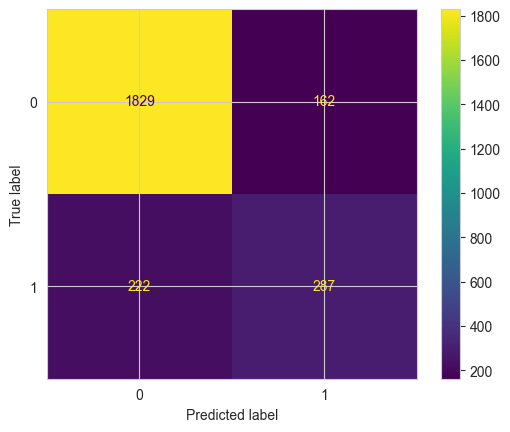

In [91]:
conf_matrix_plot(xgboost, X_test, y_test)

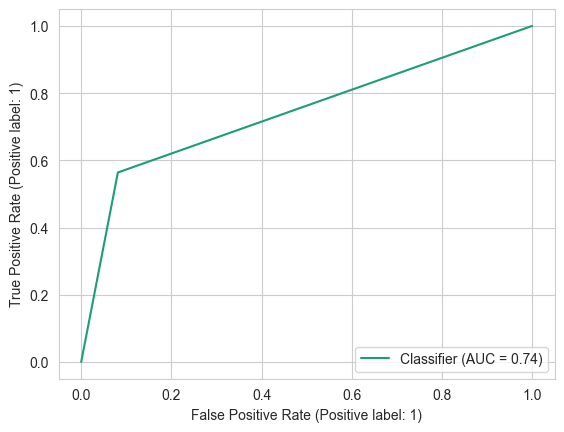

roc_auc_score: 0.741


In [92]:
RocCurveDisplay.from_predictions(y_test, y_pred_xgb)
plt.show()

print("roc_auc_score:", round(roc_auc_score(y_test, y_pred_xgb), 3))

In [93]:
comparing_models = comparing_models.append({"Model": "XGBoost", "F1": 0.599, "Precision": 0.639, "Recall": 0.564, "Accuracy": 0.846}, ignore_index= True)

comparing_models = comparing_models.sort_values(by= "F1", ascending= False).reset_index(drop= True)

comparing_models

,Model,F1,Precision,Recall,Accuracy
0,Random_Forest,0.627,0.676,0.585,0.858
1,XGBoost,0.599,0.639,0.564,0.846
2,Decision_Tree,0.597,0.596,0.597,0.836
3,Naive_Bayes,0.503,0.447,0.576,0.768
4,Logistic_Regression,0.494,0.475,0.515,0.786


# pacE: Execute Stage

**Comparing the 5 models across the different evaluation metrics based on the testing data:**

In [94]:
data = {"Model": ["Random_Forest", "Random_Forest", "Random_Forest", "Random_Forest", "XGBoost", "XGBoost", "XGBoost", "XGBoost", "Decision_Tree", "Decision_Tree", "Decision_Tree", "Decision_Tree", "Naive_Bayes", "Naive_Bayes", "Naive_Bayes", "Naive_Bayes", "Logistic_Regression", "Logistic_Regression", "Logistic_Regression", "Logistic_Regression"],\
       "Metric": ["F1", "Precision", "Recall", "Accuracy", "F1", "Precision", "Recall", "Accuracy", "F1", "Precision", "Recall", "Accuracy", "F1", "Precision", "Recall", "Accuracy", "F1", "Precision", "Recall", "Accuracy"],\
       "Score": [0.627, 0.676, 0.585, 0.858, 0.599, 0.639, 0.564, 0.846, 0.597, 0.596, 0.597, 0.836, 0.503, 0.447, 0.576, 0.768, 0.494, 0.475, 0.515, 0.786]}

comparing_models_ = pd.DataFrame(data)
comparing_models_

,Model,Metric,Score
0,Random_Forest,F1,0.627
1,Random_Forest,Precision,0.676
2,Random_Forest,Recall,0.585
3,Random_Forest,Accuracy,0.858
4,XGBoost,F1,0.599
5,XGBoost,Precision,0.639
6,XGBoost,Recall,0.564
7,XGBoost,Accuracy,0.846
8,Decision_Tree,F1,0.597
9,Decision_Tree,Precision,0.596


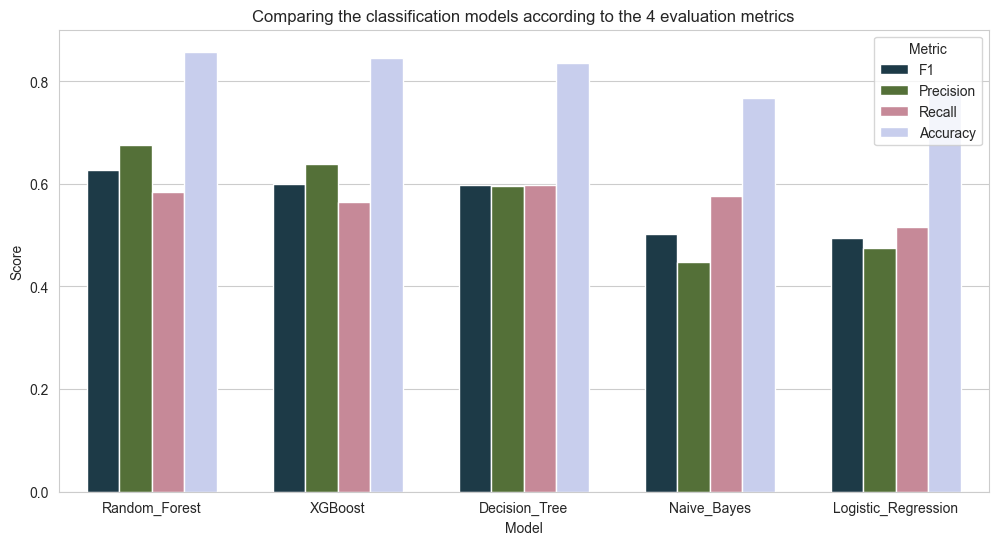

In [95]:
plt.figure( figsize= (12, 6))
fig = sns.barplot(data= comparing_models_, y= "Score", x= "Model", hue= "Metric", palette= "cubehelix", width= 0.7, dodge= True)
fig.set_title("Comparing the classification models according to the 4 evaluation metrics")
plt.show()

**We could observe that the Random Forest Model performs the best based on the `F1 Score`. However, all the models are underrated according to the supposed bank accuracy metrics, so that we can't deploy anyone of them.**

**Key Takeaways: We need more predictive features to improve the evaluation metrics of our models, since the models perform well on the cross-validation metrics, but they are poorly performing on the testing data.**